# Автор: Серегин М.С.

In [94]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import tqdm
from torch import nn
import time
from sklearn.model_selection import train_test_split
import os
import json
import seaborn as sns

# SVD

**В данном блоке реализованную модель SVD придется модифицировать.**

Для пользователей, которые проставили рейтинг меньше, чем 6 фильмам ответом будет среднее значение + смещение для фильма. 

In [2]:
class SVD:
    def __init__(self,method="SGD", n_factors=5, n_epochs=10,
                 lr=0.001,reg=0.02,random_state=1, imediatly_take=1000, cut_k=6):
        self.method = method
        self.n_epochs = n_epochs
        self.n_factors = n_factors
        self.reg = reg
        self.random_state = random_state
        self.lr=lr
        self.im_take = imediatly_take
        self.cut_k = cut_k
    
    
    def _sgd(self,df_pivot_, n_users=104563, n_items=7519): 

        df_pivot = df_pivot_.copy()
        df_pivot.columns = [["user","item","rating"]]


        P = np.random.random((n_users,self.n_factors)) * 0.0000001
        Q = np.random.random((self.n_factors,n_items)) * 0.0000001

        
        
        us = np.random.random(n_users) * 0.0000001
        it = np.random.random(n_items) * 0.0000001

        mu = float(df_pivot.rating.mean())
        
        df_pivot.index = range(len(df_pivot))
        seq_to_choose = df_pivot.index
        
        tmp = df_pivot_.groupby(by="user_id").count()
        mask = np.array((tmp < self.cut_k).item_id)
        self.not_pred = np.array(tmp.index)[mask]
   
        
        for _ in range(self.n_epochs):
            for _ in range(len(df_pivot.index)//self.im_take):
                

                ind_raw_us = np.random.choice(seq_to_choose, size=self.im_take*3,replace=False)
                m_ = df_pivot.loc[ind_raw_us][["user","item","rating"]]

                user = np.array(m_.user).reshape(-1)
                item = np.array(m_.item).reshape(-1)
                rating = np.array(m_.rating).reshape(-1)
    
                r_hat = mu + us[user] + it[item] + np.sum(P[user,:].T * Q[:,item],axis=0)
                error = (rating - r_hat)

                us[user] = us[user] + self.lr * (error - self.reg * us[user])

                r_hat = mu + us[user] + it[item] + np.diag(P[user,:] @ Q[:,item])
                error = (rating - r_hat)
                it[item] = it[item] + self.lr * (error - self.reg * it[item])

                r_hat = mu + us[user] + it[item] + np.sum(P[user,:].T * Q[:,item],axis=0)
                error = (rating - r_hat)
                P[user,:] = P[user,:] + self.lr * (error.reshape(-1,1) * Q[:,item].T -self.reg * P[user,:])


                item, idx_item = np.unique(item, return_index=True)
                user = user[idx_item]
                rating = rating[idx_item]

                r_hat = mu + us[user] + it[item] + np.sum(P[user,:].T * Q[:,item],axis=0)
                error = (rating - r_hat)
                Q[:,item] = Q[:,item] + self.lr * (error * P[user,:].T - self.reg * Q[:,item])
                
            if _ == 5:
                self.lr /= 10
                self.reg /= 10
         
  
   
        self.mu = mu
        self.P = P
        self.Q = Q
        self.it = it
        self.us = us
        
        self.zero_parameters(self.not_pred)
        
        
    def zero_parameters(self,arr_us_delete):
        self.P[arr_us_delete,:] = 0
        self.us[arr_us_delete] = 0
    


    def fit(self,df_train_):
        np.random.seed(self.random_state)
        df_train = df_train_.copy()
        if self.method == "SGD":
            self._sgd(df_train)
        else:
            self._als(df_train)

    def predict(self,pivot_predict):
        pivot = pivot_predict.copy()
        pred = np.zeros(shape=len(pivot.index))

        for i in range(len(pivot.index)):
            user, item = list(map(int, list(pivot.iloc[i])))
            

            pred[i] = self.mu + self.us[user] + self.it[item] + self.P[user,:] @ self.Q[:,item]
        return pred     

### Обработка данных



In [132]:
df = pd.read_csv("ratings.csv")

In [133]:
replace_users = dict(zip(df.user_uid.unique(), np.arange(104563)))

In [134]:
replace_items = dict(zip(df.element_uid.unique(), np.arange(7519)))

In [135]:
df["user_id"] = df.user_uid.apply(lambda x: replace_users[x])

In [136]:
df["item_id"] = df.element_uid.apply(lambda x:replace_items[x])

In [137]:
df = df.drop(["user_uid", "element_uid"], axis=1)

In [138]:
df.drop("ts",axis=1,inplace=True)

In [139]:
df = df[["user_id","item_id","rating"]]

In [140]:
mean, std = df.rating.mean(), df.rating.std()
df.rating = (df.rating - mean)/std

In [141]:
spl_fold, dataset3 = train_test_split(df,test_size=0.33)

In [142]:
dataset1, dataset2 = train_test_split(spl_fold, test_size=0.5)

In [143]:
dct_datasets = {1:dataset1, 2:dataset2, 3:dataset3}

In [144]:
print("Выдавая в качестве ответа среднее, ошибка составит:",
      np.sqrt(((((np.array(df.rating)*std)+mean) - mean)**2).mean())) # в качестве бейзлайна возьем среднее

Выдавая в качестве ответа среднее, ошибка составит: 2.0745472671203813


### SVD
### Получение матриц признаков и ошибок на валидационном датасете

В данном блоке запустим алгоритм SVD с различным числом латентных факторов, для каждого фолда сохраним P,Q,bu,bi

In [20]:
def rmse_svd(model,dataset,):
    pred = np.clip((model.predict(dataset[["user_id", "item_id"]]) * std) + mean,0,10)
    true = (dataset.rating * std) + mean
    return np.sqrt(((pred-true)**2).mean())

In [21]:
id_data = [1,2,3]
loss_dct = {8:{"train":[],"test":[]},
            10:{"train":[],"test":[]},
            12:{"train":[],"test":[]}}

parameters_dct = {8:{"parameters":[]},
                 10:{"parameters":[]},
                 12:{"parameters":[]}}

for factors in tqdm.tqdm([8,10,12]):
    for id_dataset in [1,2,3]:
        id_data.remove(id_dataset)
        train_dataset = pd.concat((dct_datasets[id_data[0]],dct_datasets[id_data[1]]))
        test_dataset = dct_datasets[id_dataset]
        
        svd = SVD(method='SGD',
            n_factors=factors,
            n_epochs=20,
            lr=0.05,
            reg=0.2, imediatly_take=300,cut_k=6
                 )

        svd.fit(train_dataset)
        
        loss_train = rmse_svd(svd, train_dataset)
        loss_test = rmse_svd(svd, test_dataset)
        
        loss_dct[factors]["train"].append(loss_train)
        loss_dct[factors]["test"].append(loss_test)
        print(f"{factors}/{id_dataset}, {loss_test}")
        
        parameters_dct[factors]["parameters"].append([svd.P, svd.Q, svd.us, svd.it])
        id_data=[1,2,3]

  0%|          | 0/3 [00:00<?, ?it/s]

8/1, 1.8662181140404648
8/2, 1.8604736672228914


 33%|███▎      | 1/3 [12:23<24:46, 743.29s/it]

8/3, 1.8658996852680367
10/1, 1.8664525891474544
10/2, 1.8605454363908591


 67%|██████▋   | 2/3 [22:14<10:53, 653.91s/it]

10/3, 1.8660034997923334
12/1, 1.866321122635173
12/2, 1.8624570278467185


100%|██████████| 3/3 [31:56<00:00, 638.87s/it]

12/3, 1.8659789416510089


# NEUMF



**Алгоритм взят из предыдущей домашней работы. В нем содержатся два блока, один из которых GMF.**

In [22]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        user_id, item_id, rating = self.df.iloc[idx]
        user_id = int(user_id)
        item_id = int(item_id)
        return [user_id,item_id], rating

In [66]:
class NNBlock(nn.Module):
    def __init__(self,in_features, out_features, fn_act=nn.GELU, batch_norm=False,p_drop_out=0.3):
        super().__init__()
        self.out_features = out_features
        
        self.linear1 = nn.Linear(in_features, out_features)
        self.act = fn_act()
        self.batch_norm = nn.BatchNorm1d(out_features) if batch_norm else nn.Identity()
        self.drop = nn.Dropout(p_drop_out) 
        
        
    def forward(self,x):
        out = self.linear1(x)
        out = self.act(out)
        out = self.batch_norm(out)        
        out = self.drop(out)
        return out
        

class Skip_module(nn.Module):
    def __init__(self,in_features, out_features,fn_act=nn.ReLU):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.act = fn_act()
        
        
    def forward(self,x):
        out = self.linear(x)
        return self.act(out)

In [67]:
class MLP_up(nn.Module):
    def __init__(self,latent_factors,amount_layers=4,fn_act=nn.GELU, base_multiply=1, p_dropout=0.3,batch_norm=False, skip=False):
        super().__init__()

 

        lt_f = latent_factors
        self.skip_indicator = 1. if skip else 0.
        
        self.block1 = NNBlock(lt_f*2+2, lt_f*2*base_multiply,fn_act, batch_norm, p_dropout)
        
        self.block2 = NNBlock(self.block1.out_features, self.block1.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout) if amount_layers > 1 else nn.Identity()
        
        self.block3 = NNBlock(self.block2.out_features, self.block2.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout) if amount_layers > 2 else nn.Identity()
        
        self.block4 = NNBlock(self.block3.out_features, self.block3.out_features*2,
                               fn_act, batch_norm, p_dropout) if amount_layers > 3 else nn.Identity()
        
        self.out_features = lt_f*2*(base_multiply**amount_layers)
        

        
        self.skip_concat_to_block4 = Skip_module(lt_f*2+2,self.block3.out_features) if amount_layers > 2 else nn.Identity()
        
    

    def forward(self,emb_us, emb_it):

        
        concat_vec = torch.concat((emb_us, emb_it),dim=1)
        
        out1 = self.block1(concat_vec) # 32 при основании 2
        out2 = self.block2(out1) # 64
        out3 = self.block3(out2) + self.skip_concat_to_block4(concat_vec) *self.skip_indicator if self.skip_indicator > 0 else self.block3(out2)
        out4 = self.block4(out3) # 256

        
        return out4

In [68]:
class GMF(nn.Module):
    def __init__(self, latent_factors,out_features=None,fn_act=nn.GELU, # out_features увеличили в два раза
                  base_multiply=2, p_dropout=0.3,batch_norm=False, skip=True):
        super().__init__()
        self.out_features = latent_factors+2 
        self.latent_factors = latent_factors
        self.block1 = NNBlock(self.latent_factors+2, self.latent_factors+2,fn_act=nn.GELU, batch_norm=False,p_drop_out=p_dropout)
        self.block2 = NNBlock(self.latent_factors+2,latent_factors+2 ,fn_act=nn.GELU, batch_norm=False,p_drop_out=p_dropout) # 32

    def forward(self,bu_, bi_, pu_, qi_):
        
        mul = pu_ * qi_ # point-wise multiplying
        x = torch.concat((mul, bu_, bi_),dim=1)
        out = self.block1(x)
        out = self.block2(out)
        
        return out
        
        
        

In [69]:
class NCF(nn.Module):
    def __init__(self,latent_factors=8,):
        super().__init__()

        self.latent_factors = latent_factors


        self.MLPblock = MLP_up(latent_factors=latent_factors,amount_layers=1)
        self.GMFblock = GMF(latent_factors=latent_factors)
     

        self.last_layer = nn.Linear(self.GMFblock.out_features + self.MLPblock.out_features, 1)
        
    def embedding(self,x):
        

        bu_ = torch.tensor([bu[x[0]]]).view(-1,1).float()
        bi_ = torch.tensor([bi[x[1]]]).view(-1,1).float()
        pu_ = torch.tensor(pu[x[0]]).float()
        qi_ = torch.tensor(qi[x[1]]).float()
    
    
        
        return bu_, bi_, pu_, qi_
    
    def forward(self,x):
        
        bu_, bi_, pu_, qi_  = self.embedding(x)
        
        svd_us = torch.concat((bu_,pu_),dim=1).float()
        svd_it = torch.concat((bi_,qi_),dim=1).float()

        
        mlp_res = self.MLPblock(svd_us, svd_it) # 256
        gmf_res = self.GMFblock(bu_, bi_, pu_, qi_) # 32
       
        concat_vec = torch.concat((mlp_res, gmf_res),dim=1) # 256 + 32
        
        out = self.last_layer(concat_vec)
        
        return out
 

In [70]:
def perform_epoch(model, loader, criterion, 
                optimizer=None):
    is_train = optimizer is not None

    if is_train:  
        model.train()
    else:
        model.eval()

    total_loss = 0
    total_n = 0
    with EmptyContext() if is_train else torch.no_grad():
        for batch_data, batch_labels in (loader):
            model_labels = model(batch_data).view(-1).float()
 

            new_loss = criterion(model_labels, batch_labels.float())
            if is_train:
              optimizer.zero_grad()
              new_loss.backward()
              optimizer.step() 

            one_batch_loss = float(criterion((model_labels*std)+mean, (batch_labels*std)+mean))

            
            total_loss += one_batch_loss
            total_n += 1 
    return total_loss / total_n 

In [71]:
class EmptyContext:
    def __enter__(self):
        pass
    
    def __exit__(self, *args):
        pass

In [72]:
def validate(model,train_dataloader, val_dataloader, n_epochs=5):
    loss_fn = nn.MSELoss()
     
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    lst_err = []
    start_time = time.time()
    for epoch in tqdm.tqdm(range(n_epochs)):
        train_loss = perform_epoch(model,train_dataloader,loss_fn,optimizer,)
        val_loss = perform_epoch(model,val_dataloader,loss_fn,None)
        lst_err.append([np.sqrt(train_loss), np.sqrt(val_loss)])



    finish_time = time.time()
    spent_time = finish_time - start_time
        
    return lst_err, spent_time 

**Валидация NeuMF**

In [145]:
l = [1,2,3]
dct_ncf = {8:[],10:[],12:[]}
for factor in [8,10,12]:
    for i in [1,2,3]:
        l.remove(i)
        train_dataset = Dataset(pd.concat((dct_datasets[l[0]],dct_datasets[l[1]])))
        val_dataset = Dataset(dct_datasets[i])

        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=256,drop_last=True,shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=1024)

        bu = parameters_dct[factor]["parameters"][i-1][2]
        bi = parameters_dct[factor]["parameters"][i-1][3]
        qi = parameters_dct[factor]["parameters"][i-1][1].T
        pu = parameters_dct[factor]["parameters"][i-1][0]


        model = NCF(latent_factors=factor)
        errors, _ = validate(model, train_dataloader, val_dataloader, n_epochs=10)
        
        er = min(np.array(errors)[:,1])
        dct_ncf[factor].append(er)
        print(f"{factor}/{i},{er}")

        l = [1,2,3]

100%|██████████| 10/10 [04:27<00:00, 26.79s/it]


8/1,1.8639729092306863


100%|██████████| 10/10 [04:24<00:00, 26.49s/it]


8/2,1.8666284065537857


100%|██████████| 10/10 [04:25<00:00, 26.51s/it]


8/3,1.8539246479239098


100%|██████████| 10/10 [04:29<00:00, 26.91s/it]


10/1,1.8633828551862623


100%|██████████| 10/10 [04:37<00:00, 27.72s/it]


10/2,1.8662370421162409


100%|██████████| 10/10 [05:01<00:00, 30.19s/it]


10/3,1.851568606841232


100%|██████████| 10/10 [04:43<00:00, 28.33s/it]


12/1,1.8647406449914676


100%|██████████| 10/10 [04:32<00:00, 27.20s/it]


12/2,1.8651720887123737


100%|██████████| 10/10 [04:42<00:00, 28.27s/it]

12/3,1.8516693719577142


# Гибридная архитектура


**Повторим предыдущий алгоритм, добавив к нему слой учитывающий контентные признаки.**

В качестве контентных признаков для фильмов из catalogue взяты features_2,  features_4. 

Также были использованы данные о фильмах, добавленных пользователем в запомненное. А именно, для каждого пользователя, который поместил более 2 фильмов (в целях робастности) в запомненное, возьмем среднее скрытое представление этих фильмов. Таким образом, получится вектор, который показывает, какие "в среднем" фильмы пользователь добавляет в запомненное. 

Отмечу недостаток такого подхода. Здесь в качестве допущения принимается утверждение о том, что близкие фильмы обладают близкими значениями Q_i, тогда при усреднении получится вектор похожий на них. Однако вектора из матрицы Q не обязаны обладать этим свойством ,как в алгоритме word2vec. С другой стороны, если два фильма, добавленных в запомненное сильно отличаются, тогда при усреднении получится "фильм", который вообще на них не похож. Например, добавив боевик и мультфильм в запомненное, при их усреднении может получится неадекватный вектор. 

Можно было бы рассмотреть подход, при котором строятся новые скрытые представления для фильмов. А именно, фильмы которые один пользователь добавил в запомненное должны быть близки с точки зрения метрики. Тогда можно для каждого пользователя проходится по множеству фильмов, добавленных в запомненное, уменьшать между ними расстояние с помощью нейросети. Сделая, это для каждого пользователя, мы получим вектора, характеризующие фильмы такие, что фильмы, которые пользователи часто добавляют вместе в запомненное будут близки. 

**Реализуем два подхода к построению гибридной архитектуры:**
1. Контентные признаки будут иметь собственные слои, результирующий вектор которых будет стыковаться к векторам из GMF, MLP.
2. Контентные признаки не будут иметь собственного блока, а будут входить в качестве дополнительных признаков вектора, подающегося на вход MLP

**1. В данной модели контентые признаки располагаются ближе к концу сети и имеют собственные слои.**

In [ ]:
class CBlock(nn.Module):
    """
    Блок на вход принимает контентные признаки.
    """
    def __init__(self,latent_factors,it_features):
        super().__init__()
        input_features = latent_factors + it_features
        
        self.out_features = input_features + 2
        self.linear1 = nn.Linear(input_features, self.out_features)
        self.gelu1 = nn.GELU()
        
    def forward(self,us_content,it_content):
        x = torch.concat((us_content,it_content),dim=1)
        
        out = self.gelu1(self.linear1(x))
        return out
        
        
        
        

In [74]:
class NCF_hybrid(nn.Module):
    def __init__(self,embeddings,
                 content_f,
                 latent_factors=8,):
        super().__init__()

        self.latent_factors = latent_factors
        self.bu = embeddings[2]
        self.bi = embeddings[3]
        self.pu = embeddings[0]
        self.qi = embeddings[1]
        self.us_bookmarks = content_f[1]
        self.it_features = content_f[0]

        self.MLPblock = MLP_up(latent_factors=latent_factors,amount_layers=1)
        self.GMFblock = GMF(latent_factors=latent_factors)
        self.Contentblock = CBlock(latent_factors=latent_factors, it_features=2)
     

        input_last_layer = self.GMFblock.out_features + self.MLPblock.out_features + self.Contentblock.out_features
        self.last_layer = nn.Linear(input_last_layer, 1)
                                    
        
    def embedding(self,x):

        bu_ = torch.tensor([self.bu[x[0]]]).view(-1,1).float()
        bi_ = torch.tensor([self.bi[x[1]]]).view(-1,1).float()
        pu_ = torch.tensor(self.pu[x[0]]).float()
        qi_ = torch.tensor(self.qi[x[1]]).float()
        
        us_content = torch.tensor(self.us_bookmarks[x[0]]).float()
        it_content = torch.tensor(self.it_features[x[1]]).float()

        
        return bu_, bi_, pu_, qi_, us_content, it_content
    
    def forward(self,x):
        
        bu_, bi_, pu_, qi_, us_content, it_content  = self.embedding(x)
        
        svd_us = torch.concat((bu_,pu_),dim=1).float()
        svd_it = torch.concat((bi_,qi_),dim=1).float()

        
        mlp_res = self.MLPblock(svd_us, svd_it) # 256
        gmf_res = self.GMFblock(bu_, bi_, pu_, qi_) # 32
        content_res = self.Contentblock(us_content,it_content)
       
        concat_vec = torch.concat((mlp_res, gmf_res, content_res),dim=1) 
        
        out = self.last_layer(concat_vec)
        
        return out

**Собираем контентные признаки**

In [75]:
DATA_PATH = './'
with open(os.path.join(DATA_PATH, 'catalogue.json'), 'r') as f:
    catalogue = json.load(f)

catalogue = {int(k): v for k, v in catalogue.items()}

In [76]:
bookmarks = pd.read_csv(
    os.path.join(DATA_PATH, 'bookmarks.csv'),
    dtype={
        'element_uid': np.uint16,
        'user_uid': np.uint32,
        'ts': np.float64
    }
)

In [77]:
def construct_content_user_features(Q,P): # на вхоод приходит матрица уже транспонированная (items, latent_factors)
    """
    Функция для каждого пользователя, который добавил хотя бы 2 фильма в запомненное
    расчитывает среднее скрытых представлений этих фильмов 
    """
    unique_users_book = bookmarks.user_uid.unique()
    us_bookmarks = np.zeros_like(P)
    for user in tqdm.tqdm(unique_users_book):
        items_booked = np.array(bookmarks[bookmarks.user_uid==user].element_uid)
        items_booked = items_booked[items_booked < 7520]
        if (len(items_booked) > 2) and (user < 104564): # добавим робастности
            us_bookmarks[user,:] = np.mean(svd.Q.T[items_booked,:])
            
            
    return us_bookmarks


In [78]:
catalogue = {key : [catalogue[key]["feature_2"], catalogue[key]["feature_4"]] for key in catalogue.keys()}

In [79]:
# формируем контентные признаки фильмов (features_2, features_4)
arr_item_features = np.zeros((7519,2))
for key in catalogue:
    if key < 7519:
        arr_item_features[key,:] = catalogue[key]
    
    

In [80]:
l = [1,2,3]
dct_co = {8:[],10:[],12:[]}
for factor in [8,10,12]:
    for i in [1,2,3]:
        l.remove(i)
        train_dataset = Dataset(pd.concat((dct_datasets[l[0]],dct_datasets[l[1]])))
        val_dataset = Dataset(dct_datasets[i])

        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=256,drop_last=True,shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=1024)

        bu = parameters_dct[factor]["parameters"][i-1][2]
        bi = parameters_dct[factor]["parameters"][i-1][3]
        qi = parameters_dct[factor]["parameters"][i-1][1].T
        pu = parameters_dct[factor]["parameters"][i-1][0]
        us_bookmarks = construct_content_user_features(qi,pu)
        
        
        pqui = [pu,qi,bu,bi]
        model = NCF_hybrid(embeddings=pqui,
                 content_f=[arr_item_features,us_bookmarks],
                 latent_factors=factor)
        errors, _ = validate(model, train_dataloader, val_dataloader, n_epochs=15)
        
        er = min(np.array(errors)[:,1])
        dct_ncf[factor].append(er)
        print(f"{factor}/{i},{er}")

        l = [1,2,3]

100%|██████████| 15/15 [06:26<00:00, 25.76s/it]


8/1,1.8641548453701613


100%|██████████| 15/15 [06:27<00:00, 25.86s/it]


8/2,1.8562327466526807


100%|██████████| 15/15 [06:26<00:00, 25.78s/it]


8/3,1.8648498171904353


100%|██████████| 15/15 [06:46<00:00, 27.12s/it]


10/1,1.8649953007679503


100%|██████████| 15/15 [06:44<00:00, 26.97s/it]


10/2,1.8590013979782665


100%|██████████| 15/15 [06:46<00:00, 27.09s/it]


10/3,1.8635568151399078


100%|██████████| 15/15 [06:42<00:00, 26.82s/it]


12/1,1.8646804591996722


100%|██████████| 15/15 [06:53<00:00, 27.60s/it]


12/2,1.8583349552268429


100%|██████████| 15/15 [06:59<00:00, 27.98s/it]

12/3,1.8616268291590268


**2. В данном блоке контентые признаки будут подаваться вначале нейросети в блок ML_up, поэтому можно обойтись без блока CBlock.**

In [90]:
class MLP_up_2(nn.Module):
    def __init__(self,latent_factors,amount_layers=4,fn_act=nn.GELU,
                 base_multiply=1, p_dropout=0.3,batch_norm=False, skip=False):
        super().__init__()

 

        lt_f = latent_factors
        self.skip_indicator = 1. if skip else 0.
        
        self.block1 = NNBlock(lt_f, lt_f,fn_act, batch_norm, p_dropout)
        
        self.block2 = NNBlock(lt_f, lt_f,
                               fn_act, batch_norm, p_dropout) if amount_layers > 1 else nn.Identity()
        
        self.block3 = NNBlock(self.block2.out_features, self.block2.out_features*base_multiply,
                               fn_act, batch_norm, p_dropout) if amount_layers > 2 else nn.Identity()
        
        self.block4 = NNBlock(self.block3.out_features, self.block3.out_features*2,
                               fn_act, batch_norm, p_dropout) if amount_layers > 3 else nn.Identity()
        
        self.out_features = lt_f
        

        
        self.skip_concat_to_block4 = Skip_module(lt_f*2+2,self.block3.out_features) if amount_layers > 2 else nn.Identity()
        


    def forward(self,emb_us, emb_it):
        
        concat_vec = torch.concat((emb_us, emb_it),dim=1)
        
        out1 = self.block1(concat_vec) 
        out2 = self.block2(out1) 
        out3 = self.block3(out2) + self.skip_concat_to_block4(concat_vec) *self.skip_indicator if self.skip_indicator > 0 else self.block3(out2)
        out4 = self.block4(out3) 

        
        return out4

In [91]:
class NCF_hybrid_2(nn.Module):
    def __init__(self,embeddings,
                 content_f,
                 latent_factors=8,):
        super().__init__()

        self.latent_factors = latent_factors
        self.bu = embeddings[2]
        self.bi = embeddings[3]
        self.pu = embeddings[0]
        self.qi = embeddings[1]
        self.us_bookmarks = content_f[1]
        self.it_features = content_f[0]

        self.MLPblock = MLP_up_2(latent_factors=latent_factors*3+4,amount_layers=2)
        self.GMFblock = GMF(latent_factors=latent_factors)

        input_last_layer = self.GMFblock.out_features + self.MLPblock.out_features
        self.last_layer = nn.Linear(input_last_layer, 1)
                                    
        
    def embedding(self,x):

        bu_ = torch.tensor([self.bu[x[0]]]).view(-1,1).float()
        bi_ = torch.tensor([self.bi[x[1]]]).view(-1,1).float()
        pu_ = torch.tensor(self.pu[x[0]]).float()
        qi_ = torch.tensor(self.qi[x[1]]).float()
        
        us_content = torch.tensor(self.us_bookmarks[x[0]]).float()
        it_content = torch.tensor(self.it_features[x[1]]).float()

        
        return bu_, bi_, pu_, qi_, us_content, it_content
    
    def forward(self,x):
        
        bu_, bi_, pu_, qi_, us_content, it_content  = self.embedding(x)
        
        svd_us = torch.concat((bu_,pu_,us_content),dim=1).float()
        svd_it = torch.concat((bi_,qi_,it_content),dim=1).float()

        
        mlp_res = self.MLPblock(svd_us, svd_it) 
        gmf_res = self.GMFblock(bu_, bi_, pu_, qi_) 
       
        concat_vec = torch.concat((mlp_res, gmf_res),dim=1) 
        
        out = self.last_layer(concat_vec)
        
        return out

In [93]:
l = [1,2,3]
dct_co2 = {8:[],10:[],12:[]}
for factor in [8,10,12]:
    for i in [1,2,3]:
        l.remove(i)
        train_dataset = Dataset(pd.concat((dct_datasets[l[0]],dct_datasets[l[1]])))
        val_dataset = Dataset(dct_datasets[i])

        train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=256,drop_last=True,shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=1024)

        bu = parameters_dct[factor]["parameters"][i-1][2]
        bi = parameters_dct[factor]["parameters"][i-1][3]
        qi = parameters_dct[factor]["parameters"][i-1][1].T
        pu = parameters_dct[factor]["parameters"][i-1][0]
        us_bookmarks = construct_content_user_features(qi,pu)
        
        
        pqui = [pu,qi,bu,bi]
        model = NCF_hybrid_2(embeddings=pqui,
                 content_f=[arr_item_features,us_bookmarks],
                 latent_factors=factor)
        errors, _ = validate(model, train_dataloader, val_dataloader, n_epochs=15)
        
        er = min(np.array(errors)[:,1])
        dct_co2[factor].append(er)
        print(f"{factor}/{i},{er}")

        l = [1,2,3]

100%|██████████| 15/15 [06:40<00:00, 26.67s/it]


8/1,1.863405924044083


100%|██████████| 15/15 [06:43<00:00, 26.90s/it]


8/2,1.8573309462013203


100%|██████████| 15/15 [06:39<00:00, 26.66s/it]


8/3,1.8625982322815995


100%|██████████| 15/15 [06:40<00:00, 26.71s/it]


10/1,1.8641171794162397


100%|██████████| 15/15 [06:41<00:00, 26.76s/it]


10/2,1.8572774853065204


100%|██████████| 15/15 [06:31<00:00, 26.10s/it]


10/3,1.8610555413569279


100%|██████████| 15/15 [06:26<00:00, 25.77s/it]


12/1,1.8630459873306182


100%|██████████| 15/15 [06:46<00:00, 27.10s/it]


12/2,1.8583567651336572


100%|██████████| 15/15 [06:49<00:00, 27.27s/it]

12/3,1.8617077519274685


**Сравнение по времени работы**

Время работы сетей отличается менее, чем на секунду на каждую эпоху (1/26), поскольку  отличием между сетями является небольшое увеличение параметров модели и небольшая модификация архитектуры.


# **Общее сравнение ахитектур с точки зрения достигнутого качества**

In [103]:
svd_arr = np.array([loss_dct[key]["test"] for key in loss_dct]).mean(axis=1)

In [104]:
ncf_arr = np.array([1.8635086545694606,1.8633961680479115,1.8625273685538517])

In [105]:
con1_arr = np.array([1.8617458030710925,1.8625178379620415,1.8604501232177861])

In [106]:
con2_arr = np.array([sum(dct_co2[key])/3 for key in dct_co2])

In [107]:
df_res = pd.DataFrame([])
df_res["SVD"] = svd_arr
df_res["NeuMF"] = ncf_arr
df_res["Content_NeuMf_1"] = con1_arr
df_res["Content_NeuMF_2"] = con2_arr

In [145]:
df_res.index = [8,10,12]

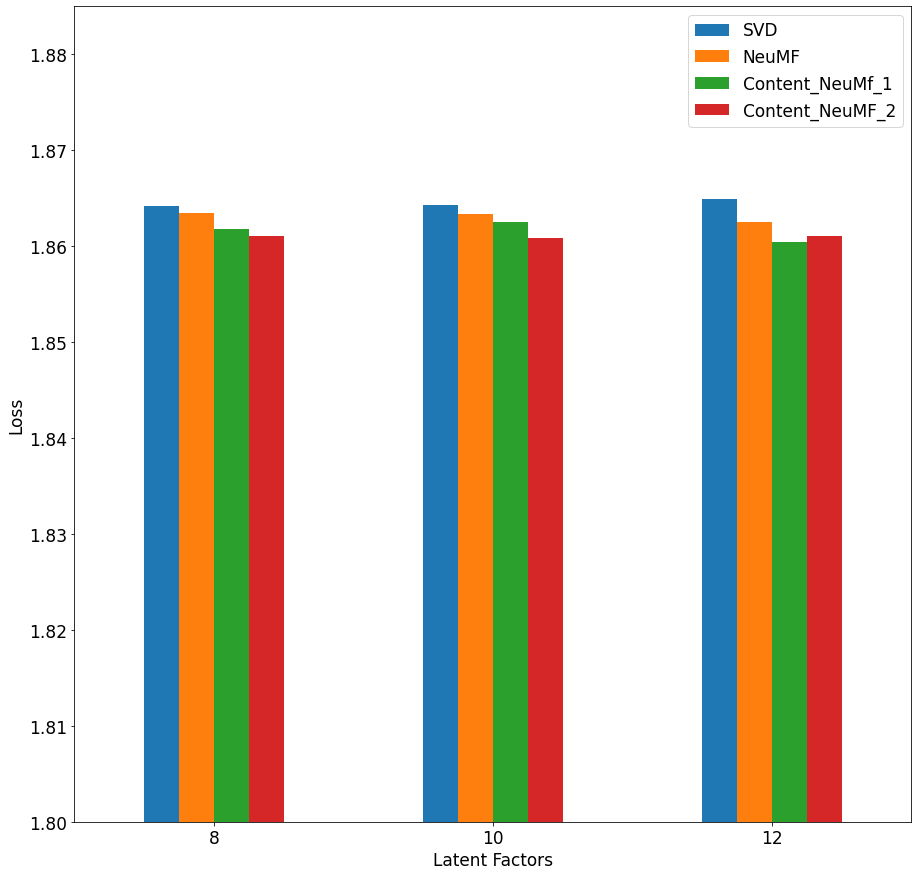

In [148]:
plt.rcParams.update({'font.size':17})
ax = df_res.plot.bar(rot=0,figsize=(15,15),ylim=(1.8,1.885), xlabel="Latent Factors", ylabel="Loss")

# Выводы:


В данной работе для задач рекомендаций применялись следующие алгоритмы:
1. SVD 
2. NeuMF 
3. Гибридная архитектура двух типов

Сформированные алгоритмом SVD матрицы P,Q, bu, bi использовались в нейросетевых архитектурах для формирования эмбеддингов.
Эксперименты показали, что добавление контентных признаков к исходной NeuMF, действительно, повышает качество модели. 
SVD, ожидаемо, показал худшее качество.

Количество скрытых признаков на качество оказал незначительное влияние. 

Из двух подходов с добавлением контентных  признаков более высокое качество показал подход, при котором контентные признаки помещаются вначале модели. Видимо, причинами являются:
1. Общее уменьшение количества параметров, что снижает переобучение и увеличивает робастность модели. 
2. Возможность контентых признаков в процессе прохождения линейного слоя входить в линейную комбинацию  с эмбеддингами, полученными с помощью матрицы Q. 
